# Downloading and Analyzing Birdnet data for the Pier
This notebook shows the BirdNET model output, deployed on Waggle edge nodes, to analyze avian diversity through acoustic monitoring. It retrieves BirdNET detection data from the node, focusing on species identification and confidence levels.

The notebook aims to provide insights into bird species presence and detection confidence within the monitored environment, demonstrating the application of edge-deployed BirdNET for ecological studies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sage_data_client

## Data Retrieval and Filtering:
Querying BirdNET output, filtering for specific nodes and removing duration data.

In [2]:


df = sage_data_client.query(
    start="2023-02-01T17:09:34.921Z",
    end="2024-02-15T17:39:34.921Z", 
    filter={
        "plugin": "registry.sagecontinuum.org/dariodematties/avian-diversity-monitoring:0.2.5",
            "vsn": "W056"
    }
)

In [3]:
df['name'].head()

0      env.detection.avian.accipiter_cooperii
1      env.detection.avian.accipiter_gentilis
2       env.detection.avian.accipiter_tachiro
3       env.detection.avian.aceros_nipalensis
4    env.detection.avian.acridotheres_tristis
Name: name, dtype: object

In [4]:
filtered_df = df[~df['name'].str.contains('duration')]
filtered_df['value'] = pd.to_numeric(filtered_df['value'], errors='coerce')
filtered_df.head()

/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_92435/2520089358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['value'] = pd.to_numeric(filtered_df['value'], errors='coerce')


,timestamp,name,value,meta.host,meta.job,meta.node,meta.plugin,meta.task,meta.vsn,meta.zone
0,2023-08-07 20:48:36.376128+00:00,env.detection.avian.accipiter_cooperii,0.223327,0000e45f01450667.ws-rpi,avian-diversity-monitoring,000048b02d3af49f,registry.sagecontinuum.org/dariodematties/avia...,avian-diversity-monitoring,W056,shield
1,2023-07-16 03:23:13.381649408+00:00,env.detection.avian.accipiter_gentilis,0.102590,0000e45f01450667.ws-rpi,avian-diversity-monitoring,000048b02d3af49f,registry.sagecontinuum.org/dariodematties/avia...,avian-diversity-monitoring,W056,shield
2,2023-10-05 20:56:11.738073344+00:00,env.detection.avian.accipiter_tachiro,0.148544,0000e45f01450667.ws-rpi,avian-diversity-monitoring,000048b02d3af49f,registry.sagecontinuum.org/dariodematties/avia...,avian-diversity-monitoring,W056,shield
3,2023-05-29 17:34:11.973331200+00:00,env.detection.avian.aceros_nipalensis,0.220944,0000e45f01450667.ws-rpi,avian-diversity-monitoring,000048b02d3af49f,registry.sagecontinuum.org/dariodematties/avia...,avian-diversity-monitoring,W056,shield
4,2023-08-01 22:16:15.105820672+00:00,env.detection.avian.acridotheres_tristis,0.102943,0000e45f01450667.ws-rpi,avian-diversity-monitoring,000048b02d3af49f,registry.sagecontinuum.org/dariodematties/avia...,avian-diversity-monitoring,W056,shield


# Species Frequency Analysis
Determining the most frequently detected bird species.

In [5]:
df_bySpecies = filtered_df.groupby("name").count()
df_bySpecies.head()

,timestamp,value,meta.host,meta.job,meta.node,meta.plugin,meta.task,meta.vsn,meta.zone
name,,,,,,,,,
env.detection.avian.accipiter_cooperii,1,1,1,1,1,1,1,1,1
env.detection.avian.accipiter_gentilis,1,1,1,1,1,1,1,1,1
env.detection.avian.accipiter_tachiro,1,1,1,1,1,1,1,1,1
env.detection.avian.aceros_nipalensis,1,1,1,1,1,1,1,1,1
env.detection.avian.acridotheres_tristis,1,1,1,1,1,1,1,1,1


Too many values for plugin.duration for debugging variable. So we will clean it.

In [6]:
# Filter out rows that contain 'duration'

df_bySpecies = df_bySpecies[df_bySpecies['value'] > 50].sort_values(by='value', ascending=False)

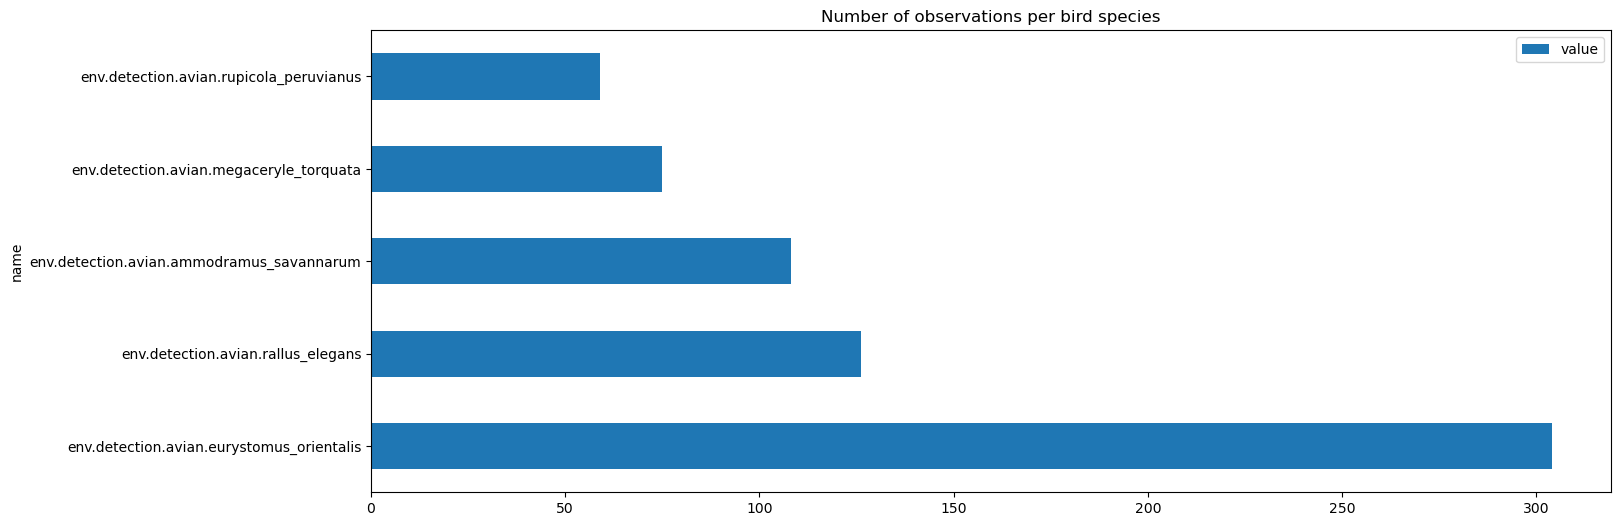

In [7]:

df_bySpecies.plot(y="value", kind="barh", title="Number of observations per bird species", figsize=(16, 6))
plt.show()

# Confidence Level Analysis 
For BirdNET, the confidence level is very important because some bird species may be identified more accurately even with lower confidence levels, while others may be less accurate despite higher confidence levels (Kahl et al., 2022).
We will be visualizing the distribution of BirdNET confidence scores, both overall and per species, to assess detection 




<Axes: ylabel='Frequency'>

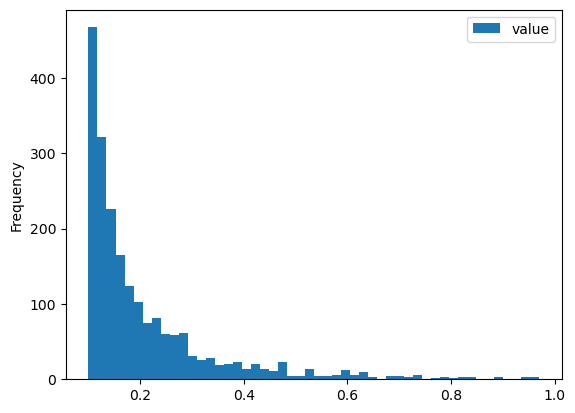

In [8]:

filtered_df.plot.hist(y="value", bins=50)


This confidence is for all species. We will separate for each bird.

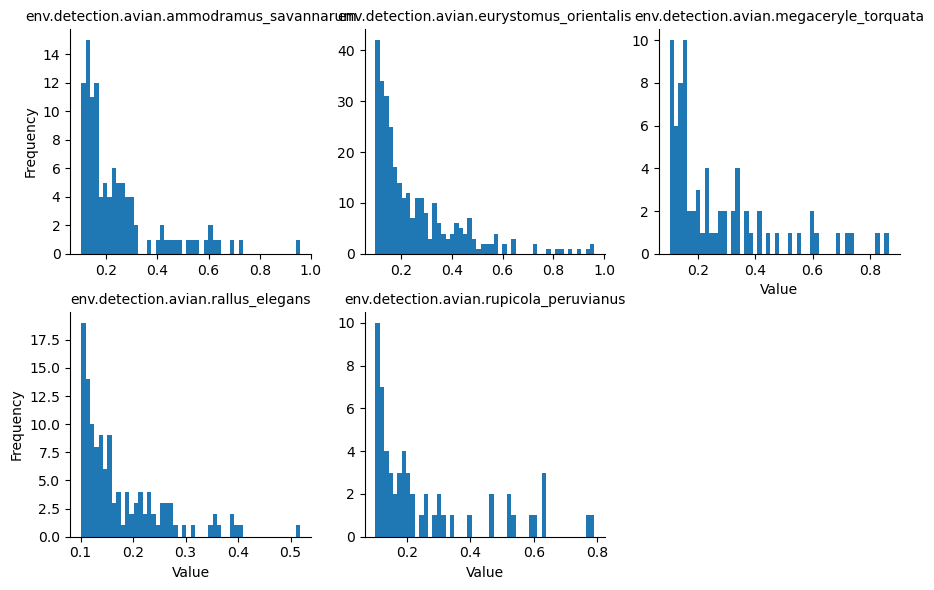

In [9]:
# Get the frequent species form df_bySpecies
species_names = df_bySpecies.index.unique()

filtered_species_df = filtered_df[filtered_df['name'].isin(species_names)]


g = sns.FacetGrid(filtered_species_df, col="name", col_wrap=3, sharex=False, sharey=False)

g.map(plt.hist, "value", bins=50)
g.set_titles("{col_name}")
g.set_axis_labels("Value", "Frequency")
plt.show()

## References
1. Dematties, D., Rajani, S., Sankaran, R., Shahkarami, S., Raut, B., Collis, S., Beckman, P. and Ferrier, N., 2024. Acoustic fingerprints in nature: A self-supervised learning approach for ecosystem activity monitoring. Ecological Informatics, 83, p.102823.
2. Kahl, S., Wood, C. M., Eibl, M., & Klinck, H. 2021. BirdNET: A deep learning solution for avian diversity monitoring. Ecological Informatics, 61, 101236.
